# 실습 8 워드 임베딩


본 실습에서 사용하는 데이터셋은 오픈 소스라 다음 사이트에서 참고할 수 있음을 밝힌다.

GloVe: Global Vectors for Word Representation (stanford.edu)

실습 데이터셋을 이용하기 위해 Google 드라이브를 mount하여 Colab에서 Google 드라이브에 저장된 파일에 접근하게 한다.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 0. 인트로

이번 실습에서는 지금까지 배운 임베딩 개념을 활용해보는 시간을 가질 것이다. 다만 주어진 GloVe라는 데이터셋은 이미 모두 임베딩이 되어있는 데이터 집합이다. 이번 실습에서 우리가 직접 임베딩을 하는 것은 아니고 임베딩이 되어있는 상태에서 유사성을 가진 단어들이 어떤 클러스터링(Clustering; 집합, 뭉치기)을 이루면서 존재하고 있는지 파악해보는 시간을 가질 것이다.

라이브러리에 해당하는 gensim을 아래 코드를 실행하여 설치한다.

In [2]:
!pip install gensim


### 1. GloVe 임베딩 불러오기

GloVe는 이미 알고리즘을 통해 학습된 워드 임베딩 데이터다. 실습은 이 GloVe라는 데이터셋을 바탕으로 행해질 것이고 50차원에 임베딩된 버전을 사용할 것이다.

먼저,‘glove.6B.50d.txt.w2v' 파일의 경로를 설정한다. 반드시 압축 해제해야 하는 것을 잊지 말고 아래 코드에 나온 path에 입력된 경로 양식을 참고하길 바란다. (참고로 이 파일들은 50차원 공간에서 임베딩된 단어 벡터가 포함되어 있다. 여기서 단어 벡터란 개념이 잘 와닿지 않는다면 워드 임베딩 이론 부분에서 배운 내용을 떠올려보자. ‘happy’라는 단어가 있었다면 이를 2차원 공간에 임베딩하여 [0.02, -0.01]과 같은 벡터로 나타낼 수 있었다.)

In [3]:
from collections import defaultdict
import numpy as np
import time
import gensim
from gensim.models.keyedvectors import KeyedVectors
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt

# GloVe 파일 경로
path = "/content/drive/MyDrive/glove.6B.50d.txt.w2v"  # 같은 경로

# Glove 파일을 Gensim
t0 = time.time()
glove = KeyedVectors.load_word2vec_format(path, binary=False)

위 코드에서 ‘glove’에 주목해보자. GloVe를 정의한 우변을 보면 ‘path’가 명시되어 있는데 path는 우리가 데이터셋을 저장한 경로로 설정해두었으므로 glove는 임베딩된 데이터를 나타낼 것이다. 다만 우리가 gensim에서 사용하는 KeyedVectors란 함수로 불러왔기 때문에 단어가 key로, 단어 벡터가 value로 존재하는 형태로 나타난다. 따라서 우리가 glove[“apple”]이란 코드를 실행시킨다면 apple에 대응하는 임베딩 벡터가 출력된다. 그럼 다음 사항을 생각해보자.


In [4]:
# Numpy array나 tuple처럼 단어 벡터의 유형(type)과 그 shape을 얻어보는 방법을 생각해보자.
# 단어는 glove에 포함되어있는 “rose”로
# shape은 말 그대로 단어가 어떤 shape을 이루며 임베딩 되어 있는지 알려준다.
# 예를 들어, 5 X 6 행렬의 경우 (5, 6)의 shape 값을 갖는다.

# 여기에 코드 작성
v = glove['rose']

print(v)
print(f"Type : {type(v)}")
print(f"Shape : {v.shape}")

[-0.80901   0.2091    0.85659   0.18123   1.0849   -0.075861 -0.82726
 -0.96318  -0.40827   0.45425   0.4642   -0.58634  -0.014735 -1.0625
  0.39668   0.19313  -1.2619   -0.35233  -1.019    -0.63384   1.2078
  0.18914   0.055527 -1.117    -0.7025   -0.58161   0.064159 -0.030037
 -0.1067    0.44689   2.8481    0.12098   1.2057    0.93686   0.48936
 -1.5921   -0.87753  -0.32164   1.0237   -0.70042  -0.54317   0.1281
  0.54337  -0.86638   0.065663  0.017083 -0.12465  -0.61839   0.14818
 -0.032635]
Type : <class 'numpy.ndarray'>
Shape : (50,)



### 2. 유사한 단어 찾아보기

임베딩이 되어 있는 단어들은 임베딩 된 공간에서 유사성을 갖는 단어들끼리 클러스터링을 이루는 것을 알고 있다. 그렇기에 우리는 임베딩 데이터를 기반으로, most_similar 함수를 이용해서 특정 단어와 유사한 단어들을 추출해낼 수 있다. (물론 출력으로 나온 유사한 단어도 당연히 데이터셋 안에 있는 단어이다.) 이번 실습에서는 glove.most_similar("word")라는 코드를 사용하면 된다. 그 결과를 출력해보면 우리가 입력해 준 “word”와 유사어들과 함께 그에 대응하는 단어 벡터도 함께 출력되는 것을 확인할 수 있을 것이다.

이 함수는 단어 벡터 간 코사인 유사성(cosine similarity)을 기반으로 유사한 단어를 찾는다. 여기서 코사인 유사성이란 각 단어가 갖는 단어 벡터끼리 이루는 각도에 대응하는 코사인값을 이용해 단어 간 유사도를 평가하는 방식이다. 두 단어 벡터의 방향이 유사할수록 비슷한 단어이고, 이므로 코사인 값이 1에 가까울수록 유사한 단어라고 생각할 수 있다.

In [5]:
# 코사인 유사성에 따라 어떤 단어가 주어졌을 때 그 단어와 가장 유사한 단어를 모델이 골라내는 것이 다음 코드로 가능하다.
# Hint: glove.most_similar("word")
# ‘funny’와 ‘pencil’이란 단어에 대해 이 작업을 시행해보자.

# 여기에 코드 작성
print(glove.most_similar("funny"))
print(glove.most_similar("pencil")) #해당단어와 유사한 단어들을 유사도와 함께 출력해줌!

[('hilarious', 0.8796553611755371), ('amusing', 0.8676608204841614), ('silly', 0.8449272513389587), ('joke', 0.8393374681472778), ('fun', 0.8367612957954407), ('weird', 0.8209654092788696), ('pretty', 0.8184577822685242), ('scary', 0.8148325085639954), ('boring', 0.8118149042129517), ('incredibly', 0.7985020875930786)]
[('scissors', 0.7837907671928406), ('sharpener', 0.7752447128295898), ('pencils', 0.7656055688858032), ('crayon', 0.738135039806366), ('sharpeners', 0.7206111550331116), ('engraving', 0.7164567708969116), ('paint', 0.7089575529098511), ('lettering', 0.7048622369766235), ('eraser', 0.7036406993865967), ('lace', 0.6947881579399109)]





### 3. 고차원의 데이터를 차원 축소를 통해 시각화하기
우리가 사용하고 있는 glove에는 50차원과 같이 매우 높은 차원에서의 임베딩이 존재하고 있어서 단어들이 서로 어떤 위치 관계를 이루며 50차원의 공간에 존재하는지 알기 쉽지 않다. 이를 가시적으로 한 번에 보기 위해선 50차원을 2차원이나 3차원처럼 좀 더 작은 차원으로 축소할 필요가 있다. 이를 위해 Scikit-learn의 TruncatedSVD을 이용하여 차원을 줄일 것이다. 본격적으로 실습을 수행하기 전에 중요하게 사용될 코드를 짚고 넘어가자.

첫째로, 차원 축소 모델을 svd = TruncatedSVD(n_components=2) 코드로 생성한다.
둘째로, 새로 생성한 모델 svd를 ‘X_train’이란 이름을 갖는 데이터로 학습시켜주기 위해 fit() 함수를 이용한다.

=> svd.fit(X_train)

마지막으로, 50차원의 행렬 혹은 벡터 X에 대해 그 차원을 2차원으로 축소하려면 함수 transform()을 사용하면 된다.

=> X_reduced = svd.transfrom(X)

모든 임베딩 데이터에 대하여 차원 축소를 해야 하다 보니 방대한 데이터를 하나로 옮겨놓는 작업이 필요하다. 이를 위해 워드 임베딩을 하나의 행렬로 옮겨 합쳐놓는 작업을 거칠 것이다. 아래의 코드에서는 행렬 shape을 지정하여 영행렬 모든 요소가 0인 행렬
을 먼저 생성한 후 그곳에 glove[word], 즉 ‘word’에 대응하는 임베딩 벡터를 각 행에 추가하여 행렬을 형성하고 있다.


In [6]:
len(glove.key_to_index)

400000

In [7]:
d = glove.vector_size
d

50

In [8]:
#하나의 행렬로 합침
n = len(glove.key_to_index)
d = glove.vector_size
X_glove = np.zeros((n, d))
for i, word in enumerate(glove.key_to_index.keys()):
    X_glove[i,:] = glove[word]
X_glove.shape

(400000, 50)

In [9]:
# enumerate 예시
#i는 인덱스, text는 내용
ex_list = ['a', 'b' ,'c']
for i, text in enumerate(ex_list):
    print(i)
    print(text)

0
a
1
b
2
c


이 코드로 우린 X_glove에 단어들이 존재하는 행렬을 생성하는 작업까지 마무리했다. 위에서 배운 코드를 토대로 svd 모델을 생성한 후, X_glove란 행렬로 svd 모델을 학습시키는 코드 작성을 마무리해보자.

In [10]:
# svd : 압축을 통해 차원을 축소시킴
svd = TruncatedSVD(n_components=2)
svd.fit(X_glove)

TruncatedSVD()


### 4. 시각화를 위한 함수 작성

이제 2차원 임베딩 공간에 단어 쌍들이 존재하므로 이 쌍들이 어떤 분포를 이루고 있는지, 한마디로 어떻게 ‘mapping(매핑, 대응)’ 되어있는지를 시각화해보는 것이 이번 실습의 마지막 단계이다. 지금부터는 주어진 코드를 이해하는 것을 목표로 하자. 아래의 plot_pairs란 함수는 단어를 시각적으로 표현해주고자 하는 코드이다. 주석을 따라가다보면 우리가 방금 배웠던 행렬 생성과 더불어 데이터를 시각화하는 여러 방식을 공부할 수 있을 것이다.

In [11]:
def plot_pairs(words, word_vectors, svd):
    """ 2차원에서 단어쌍을 도식화.

    매개변수(Parameters)
    ----------
    words: list[str]
        짝수 개의 단어들이 들어있는 목록으로 공통적인 관계를 바탕으로 단어들이 쌍을 이루고 있다.
        (예를 들면 직업과 그 직업이 사용하는 도구와 같은 관계)
         e.g, ["목수", "도끼", "배관공", “렌치"].

    word_vectors: KeyedVectors의 인스턴스
        gensim의 KeyedVectors wrapper에 있는 워드 임베딩 모델

    svd: TruncatedSVD의 인스턴스
        이미 데이터로 학습된 truncated SVD의 인스턴스 (n_components=2로).
    """

    # 2차원에 단어를 매핑하기
    d = word_vectors.vector_size
    words_temp = np.zeros((len(words), d))
    for i, word in enumerate(words):
        words_temp[i,:] = word_vectors[word]
    words_2D = svd.transform(words_temp)
    # (len(words), 2)

    # 점 나타내기
    plt.scatter(words_2D[:,0], words_2D[:,1])

    # 라벨 나타내기
    for i, txt in enumerate(words):
        plt.annotate(txt, (words_2D[i, 0], words_2D[i, 1]))

    # 선 나타내기
    for i in range(int(len(words)/2)):
        plt.plot(words_2D[i*2:i*2+2,0], words_2D[i*2:i*2+2,1], linestyle='dashed', color='k')


### 5. plot_pairs 함수로 임베딩 시각화해보기

이제 plot_pairs 함수를 이용해 2차원 공간에 비슷한 단어들끼리 클러스터링을 형성하고 있는지 확인해서 임베딩이란 개념을 확실히 이해하고 넘어가보자. (여자, 남자)나 (형용사, 비교급) 등 공통적인 기준에 따라 묶을 수 있는 단어들을 plot_pair 함수로 시각화하면 임베딩이 어떻게 됐는지 알 수 있을 것이다.


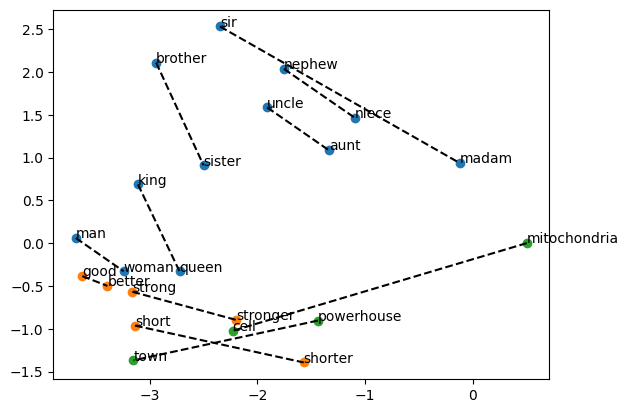

In [12]:
words = ["man", "woman", "king", "queen", "uncle", "aunt", "nephew", "niece", "brother", "sister", "sir", "madam"]
# 여성 그리고 남성에 따라

# glove에 포함된 단어들 중 위와 같은 ‘words’란 단어 조합이 어떻게 2차원 임베딩 공간에 존재하는지 알고 싶다면
# plot_pair 함수를 활용하면 된다.

plot_pairs(words, glove, svd)

# 시각적으로 어떻게 나타나는지 더 알고 싶다면 아래의 코드도 실행해보면 좋다.
words_2 =["short","shorter","strong","stronger","good","better"] # 형용사와 비교급
plot_pairs (words_2, glove, svd)

words_3 =["mitochondria","cell","powerhouse","town"]
plot_pairs (words_3, glove, svd)



### 6. 유추 문제에 임베딩 적용하기

마지막으로 ‘a와 b의 관계는 c와 d의 관계와 같다’에서 d를 임베딩 행렬로 구하는 방법을 생각해보면서 이번 실습을 마무리하자. a, b, c에 오는 단어를 안다는 가정하에 d에 어떤 단어가 오게 될지 유추해보는 과정을 실습해볼 것이다. d의 단어 벡터(임베딩된 벡터)를 알아내면 그 벡터에 대응하는 단어를 glove에서 찾는 것이 가능하다. 그 벡터는 ‘c+(b-a)’로 나타낼 수 있다. 이 벡터를 query란 이름으로 정의한 후 glove.similar_by_vector(query)로 query와 유사한 단어를 얻을 수 있다.

In [13]:
query = glove["kitten"] - glove["puppy"] + glove["dog"]
glove.similar_by_vector(query)

# a - b = c - d ; "a와 b의 관계가 c와 d의 관계와 같다"
# d = c + b - a ; 이항해서 정리해줌

[('dog', 0.7938328981399536),
 ('cat', 0.7667654752731323),
 ('kitten', 0.7179057598114014),
 ('monkey', 0.7019667625427246),
 ('killer', 0.6938791871070862),
 ('mad', 0.691328763961792),
 ('dogs', 0.6863180994987488),
 ('monster', 0.6793158650398254),
 ('woman', 0.6672138571739197),
 ('naked', 0.666832447052002)]

위 코드를 참고해 "france" is to "paris" as "germany" is to “?” 라는 예문에서 물음표에 들어갈 단어를 출력할 수 있는 코드를 작성해보자.


In [14]:
# 여기에 코드 작성
query = glove["germany"] - glove["france"] + glove["paris"]
glove.similar_by_vector(query)

[('berlin', 0.9181488752365112),
 ('frankfurt', 0.8184096217155457),
 ('munich', 0.8120746612548828),
 ('vienna', 0.8101339936256409),
 ('germany', 0.804895281791687),
 ('hamburg', 0.7974335551261902),
 ('stockholm', 0.7717639207839966),
 ('warsaw', 0.7688193917274475),
 ('budapest', 0.7663007974624634),
 ('prague', 0.7654389142990112)]

gensim 라이브러리에는 위처럼 벡터를 지정해서 단어를 찾는 방법 말고 더 간편한 방법도 있다. 바로 ‘most_similar_cosmul()’를 활용한 것이다. 차이점은 벡터를 계산할 때 앞에 (+) 부호가 붙었던 단어를 positive, (-) 부호가 붙었던 단어를 ‘negative’라 생각하고 코드에 입력해야 한다. 정리하자면, 만약 ‘positive’와 ‘negative’한 관계가 같이 존재하는 문장이라면 여기서 더 나아간 ‘most_similar_cosmul()’ 함수를 사용할 수 있다.

예를 들어 기존에는 glove["kitten"] - glove["puppy"] + glove["dog"]란 벡터를 생성한 후 물음표에 올 단어를 구했다면, 방금 배운 함수를 이용해 코드 한 줄로 쉽게 물음표 안에 들어갈 말을 구할 수 있다.

In [15]:
#유사도 곱을 이용한거여서 위에 단순히 코사인유사도사용한것보다 더 정확한 결괏값이 나오게됨
glove.most_similar_cosmul(positive=['kitten', 'dog'], negative=['puppy']) #+값을 positive에다가 -값을 negative에다가 넣어줌

[('cat', 0.8933362364768982),
 ('monkey', 0.8776191473007202),
 ('killer', 0.866765022277832),
 ('bikini', 0.8635241389274597),
 ('mad', 0.8598142266273499),
 ('naked', 0.8578193783760071),
 ('monster', 0.855743944644928),
 ('teen', 0.8467973470687866),
 ('boy', 0.8466870188713074),
 ('woman', 0.8466081619262695)]

"france" is to "paris" as "germany" is to “?” 에도 적용해보자.

In [16]:
# 여기에 코드 작성
glove.most_similar_cosmul(positive=['germany', 'paris'], negative=['france'])

[('berlin', 0.9875683188438416),
 ('frankfurt', 0.9353715777397156),
 ('vienna', 0.9297984838485718),
 ('munich', 0.9265624284744263),
 ('hamburg', 0.9223735332489014),
 ('stockholm', 0.9121066927909851),
 ('budapest', 0.9109797477722168),
 ('prague', 0.9057857394218445),
 ('warsaw', 0.9043149948120117),
 ('amsterdam', 0.8915085196495056)]



### 배운 내용 되돌아보기

□ 임베딩이 되어있는 데이터셋 GloVe 내의 데이터가 클러스터링을 잘 형성하고 있는지 확인하기 위해 .most_similar() 함수로 유사한 단어를 찾아보았다.

□ 특정 기준에 따라(e.g. 형용사와 비교급) 단어들이 어떤 위치 관계를 가지며 매핑되어 있는지 확인하기 위해 plot_pairs란 함수를 만들고 이를 시각화에 이용했다.

□ plot_pairs 함수로 특정 기준에 따라 나눈 단어가 어떻게 2차원 공간에 매핑되어 있는지 눈으로 확인했다.

□ 마지막으로 문장을 이루고 있는 단어가 갖는 단어 벡터로 빈칸에 들어갈 단어를 유추할 수 있음을 확인하였다.

참고문헌
<2. Lexical analysis>, 《Python 공식 사이트》, <https://docs.python.org/3/reference/lexical_analysis.html#string-and-bytes-literals>